<a href="https://colab.research.google.com/github/Jack2208/ML-Project/blob/main/Demo_ML_Sec_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Setup
This section contains the general setup that needs to be runned for all the models

## Installation of Dependencies

In [ ]:
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install torch
!pip install torchvision
!pip install torchaudio
!pip install foolbox

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-txk_59n1
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-txk_59n1
  Resolved https://github.com/RobustBench/robustbench.git to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-fdk3fayk/autoattack_407426f5a5ef45e6b7bb4ce94d6f3dbb
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-fdk3fayk/autoattack_407426f5a5ef45e6b7bb4ce94d6f3dbb
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [ ]:
import torch
from robustbench.data import load_cifar10
from robustbench.utils import load_model
from autoattack import AutoAttack
import foolbox as fb
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import re
import io
from google.colab import drive

# Mount Google Drive for saving results
drive.mount('/content/drive')

# Set up output directory
output_dir = "/content/drive/My Drive/robustbench_results"
os.makedirs(output_dir, exist_ok=True)

Mounted at /content/drive


## Definition of Variables and Functions

In [ ]:
# Define epsilon for AutoAttack and FMN threshold
epsilon = 8 / 255

# Detect device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# List of models to evaluate
models = [
    #"Carmon2019Unlabeled",
    #"Wang2023Better_WRN-28-10",
    #"Cui2023Decoupled_WRN-28-10"
    #"Xu2023Exploring_WRN-28-10",
    "Rade2021Helper_extra"
]

# Number of test samples
n_examples = 10

print("Setup complete.")

Using device: cuda
Setup complete.


In [ ]:
#plotta tutto tranne il sample col noise

def save_and_plot_all_norms(model, model_name, images, labels, adv_images_autoattack, adv_dict, output_dir, max_plots_to_show=1, scaling_factor=10):
    """
    Saves all adversarial perturbation plots to disk and displays a limited number on screen
    for each norm.

    Parameters:
        model: PyTorch model in evaluation mode.
        model_name: String name of the model (used for output directory structure).
        images: Original images tensor.
        labels: True labels tensor.
        adv_images_autoattack: Adversarial images generated by AutoAttack.
        adv_dict: Dictionary with norms as keys and adversarial images (from FMN) as values.
        output_dir: Base output directory to save images.
        max_plots_to_show: Maximum number of plots to display on screen per norm.
        scaling_factor: Factor to scale the perturbations for visualization.
    """
    # Set model to evaluation mode and compute predictions for AutoAttack adversarial images
    model.eval()
    autoattack_preds = model(adv_images_autoattack).argmax(dim=1).cpu().numpy()

    for norm, fmn_adv in adv_dict.items():
        # Create a directory for the current norm
        norm_output_dir = os.path.join(output_dir, model_name, f"{norm}_images")
        os.makedirs(norm_output_dir, exist_ok=True)

        # Get predictions for FMN adversarial images
        fmn_preds = model(fmn_adv).argmax(dim=1).cpu().numpy()

        for i in range(len(images)):
            fig, axes = plt.subplots(1, 5, figsize=(12, 3))

            # Prepare images for display and saving
            original = images[i].cpu().numpy().transpose(1, 2, 0)
            autoattack_img = adv_images_autoattack[i].cpu().numpy().transpose(1, 2, 0)
            fmn_img = fmn_adv[i].cpu().numpy().transpose(1, 2, 0)

            # Compute scaled perturbations
            autoattack_perturb = (autoattack_img - original) * scaling_factor
            fmn_perturb = (fmn_img - original) * scaling_factor

            # Plot the images and their predictions
            axes[0].imshow(np.clip(original, 0, 1))
            axes[0].set_title(f"Original\nLabel: {labels[i].item()}")

            axes[1].imshow(np.clip(autoattack_img, 0, 1))
            axes[1].set_title(f"AutoAttack\nPred: {autoattack_preds[i]}")

            axes[2].imshow(np.clip(fmn_img, 0, 1))
            axes[2].set_title(f"{norm}\nPred: {fmn_preds[i]}")

            axes[3].imshow(np.clip(autoattack_perturb, 0, 1))
            axes[3].set_title("AA Perturbation")

            axes[4].imshow(np.clip(fmn_perturb, 0, 1))
            axes[4].set_title(f"{norm} Perturbation")

            for ax in axes:
                ax.axis("off")

            plt.tight_layout()

            # Save the plot on disk
            image_path = os.path.join(norm_output_dir, f"sample_{i}.png")
            plt.savefig(image_path)

            # Display only the first `max_plots_to_show` samples per norm
            if i < max_plots_to_show:
                plt.show()

            plt.close()

    print("Function execution complete.")


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to apply randomized smoothing and visualize results
def randomized_smoothing(model, images, labels, sigma=0.25, num_samples=20, num_plot_samples=1):
    """
    Applies randomized smoothing to a model by adding Gaussian noise to input images.
    Also plots all noisy samples for selected images with their predicted labels and the majority-voted label.

    Parameters:
        model: PyTorch model in evaluation mode.
        images: Tensor of images to classify.
        labels: True labels tensor.
        sigma: Standard deviation of Gaussian noise.
        num_samples: Number of noisy samples per image.
        num_plot_samples: Number of images to visualize.

    Returns:
        Smoothed accuracy over num_samples.
    """
    model.eval()
    correct = 0
    total = len(images)
    plot_indices = np.random.choice(total, num_plot_samples, replace=False)  # Randomly select images for visualization

    for i in range(total):
        noisy_preds = []
        noisy_images = []  # Store noisy images for visualization
        predicted_labels = []  # Store predicted labels for visualization

        for _ in range(num_samples):
            noisy_image = images[i] + torch.randn_like(images[i]) * sigma
            noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure valid pixel range
            output = model(noisy_image.unsqueeze(0))
            pred_label = output.argmax(dim=1).item()
            noisy_preds.append(pred_label)

            if i in plot_indices:
                noisy_images.append(noisy_image.cpu().detach().numpy())  # Store for visualization
                predicted_labels.append(pred_label)

        # Majority vote
        final_pred = max(set(noisy_preds), key=noisy_preds.count)
        if final_pred == labels[i].item():
            correct += 1

        # Plot the noisy images if the index is in the selected plot samples
        if i in plot_indices:
            fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 3))  # Adjust size for better visibility
            fig.suptitle(f"True: {labels[i].item()} | Final Predicted: {final_pred}", fontsize=14)

            for j, ax in enumerate(axes):
                ax.imshow(np.transpose(noisy_images[j], (1, 2, 0)))  # Convert from Tensor format
                ax.set_title(f"Pred: {predicted_labels[j]}", fontsize=10)
                ax.axis("off")

            plt.show()

    return correct / total * 100


# Apply randomized smoothing to models
sigma = 0.25  # Noise standard deviation
num_samples = 50  # Number of noise samples per image

In [ ]:
# Load CIFAR-10 test samples
images, labels = load_cifar10(n_examples)
images, labels = images.clone().detach().to(device), labels.clone().detach().to(device)

attack_progress = {}
model_results = {}

fmn_attacks = {
    "Linf": fb.attacks.LInfFMNAttack(),
    "L2": fb.attacks.L2FMNAttack(),
    "L1": fb.attacks.L1FMNAttack(),
    "L0": fb.attacks.L0FMNAttack(),
}

print("Dataset loaded and storage initialized.")

100%|██████████| 170M/170M [00:04<00:00, 38.3MB/s]


Dataset loaded and storage initialized.


# Model 1: Carmon2019Unlabeled


## Clean Accuracy

In [ ]:
model_name = models[0]
print(f"\n==== Evaluating model: {model_name} ====")

# Load and prepare model
model = load_model(model_name=model_name, dataset="cifar10", threat_model="Linf").to(device)
model.eval()

# Classification before attacks (Clean accuracy)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
clean_accuracy = (predicted == labels).sum().item() / len(labels) * 100
print(f"\nClean Accuracy: {clean_accuracy:.2f}%")
# Print the true labels
print(f"True labels: {labels}")


==== Evaluating model: Rade2021Helper_extra ====


Downloading...
From (original): https://drive.google.com/uc?id=1GhAp-0C3ONRy9BxIe0J9vKc082vHvR7t
From (redirected): https://drive.google.com/uc?id=1GhAp-0C3ONRy9BxIe0J9vKc082vHvR7t&confirm=t&uuid=b2e4dba6-258b-48be-8a80-421f4be9455e
To: /content/models/cifar10/Linf/Rade2021Helper_extra.pt
100%|██████████| 185M/185M [00:04<00:00, 38.2MB/s]



Clean Accuracy: 100.00%
True labels: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1], device='cuda:0')


## AutoAttack

setting parameters for standard version



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/autoattack/checks.py", line 100, in check_dynamic
    sys.settrace(tracefunc)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/autoattack/checks.py", line 102, in check_dynamic
    sys.settrace(None)




--- Starting AutoAttack ---
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 6 out of 10 successfully perturbed
robust accuracy after APGD-CE: 40.00% (total time 7.4 s)
apgd-t - 1/1 - 0 out of 4 successfully perturbed
robust accuracy after APGD-T: 40.00% (total time 38.7 s)
fab-t - 1/1 - 0 out of 4 successfully perturbed
robust accuracy after FAB-T: 40.00% (total time 103.1 s)
square - 1/1 - 0 out of 4 successfully perturbed
robust accuracy after SQUARE: 40.00% (total time 185.8 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 40.00%

Predicted labels AA: tensor([5, 8, 1, 0, 4, 6, 1, 4, 5, 9], device='cuda:0')
Correct predictions AA: 4/10 (40.00%)


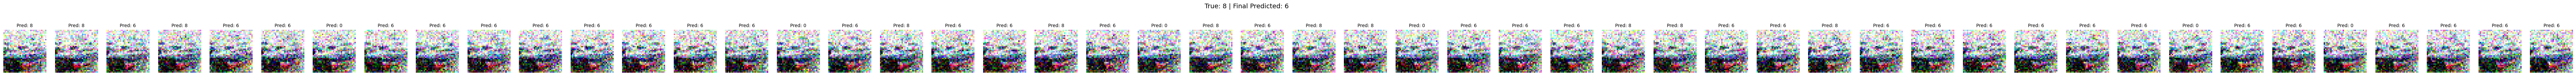

Smoothed Accuracy on AutoAttack Samples: 40.00%


In [ ]:
# Initialize AutoAttack
autoattack = AutoAttack(model, norm='Linf', eps=epsilon, version='standard', device=device)

# Capture stdout while also printing progress
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()
print("\n--- Starting AutoAttack ---")

start_aa = time.time()
adv_images_autoattack = autoattack.run_standard_evaluation(images, labels, bs=50)
end_aa = time.time()

sys.stdout = old_stdout  # Restore stdout
aa_log = mystdout.getvalue()
print(aa_log)  # Print the captured log for visibility

# Get AutoAttack predicted labels and wrong indexes
_, predicted_aa = model(adv_images_autoattack).max(1)
print(f"Predicted labels AA: {predicted_aa}")
correct = torch.sum(labels == predicted_aa)
total = len(labels)
print(f"Correct predictions AA: {correct}/{total} ({correct/total*100:.2f}%)")


# Test randomizedz smoothing on adversarial examples

smoothed_acc_autoattack = randomized_smoothing(model, adv_images_autoattack, labels, sigma, num_samples)
print(f"Smoothed Accuracy on AutoAttack Samples: {smoothed_acc_autoattack:.2f}%")

# Parse the log using regex to extract robustness and time
pattern_init    = r'initial accuracy:\s*([\d\.]+)%'
pattern_apgdce  = r'robust accuracy after APGD-CE:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'
pattern_apgdt   = r'robust accuracy after APGD-T:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'
pattern_fabt    = r'robust accuracy after FAB-T:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'
pattern_square  = r'robust accuracy after SQUARE:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'

m_init   = re.search(pattern_init, aa_log)
m_apgdce = re.search(pattern_apgdce, aa_log)
m_apgdt  = re.search(pattern_apgdt, aa_log)
m_fabt   = re.search(pattern_fabt, aa_log)
m_square = re.search(pattern_square, aa_log)

if m_init and m_apgdce and m_apgdt and m_fabt and m_square:
    initial_acc = float(m_init.group(1))
    apgdce_acc  = float(m_apgdce.group(1))
    apgdce_time = float(m_apgdce.group(2))
    apgdt_acc   = float(m_apgdt.group(1))
    apgdt_time  = float(m_apgdt.group(2))
    fabt_acc    = float(m_fabt.group(1))
    fabt_time   = float(m_fabt.group(2))
    square_acc  = float(m_square.group(1))
    square_time = float(m_square.group(2))
else:
    print("Error: Unable to parse AutoAttack log output.")

aa_times = [0.0, apgdce_time, apgdt_time, fabt_time, square_time]
aa_accuracies = [initial_acc, apgdce_acc, apgdt_acc, fabt_acc, square_acc]
aa_steps = ["Initial", "APGD-CE", "APGD-T", "FAB-T", "SQUARE"]

attack_progress[model_name] = list(zip(aa_times, aa_accuracies, aa_steps))


Saved AutoAttack progress plot (all models) to: /content/drive/My Drive/robustbench_results/autoattack_progress_all_models.png



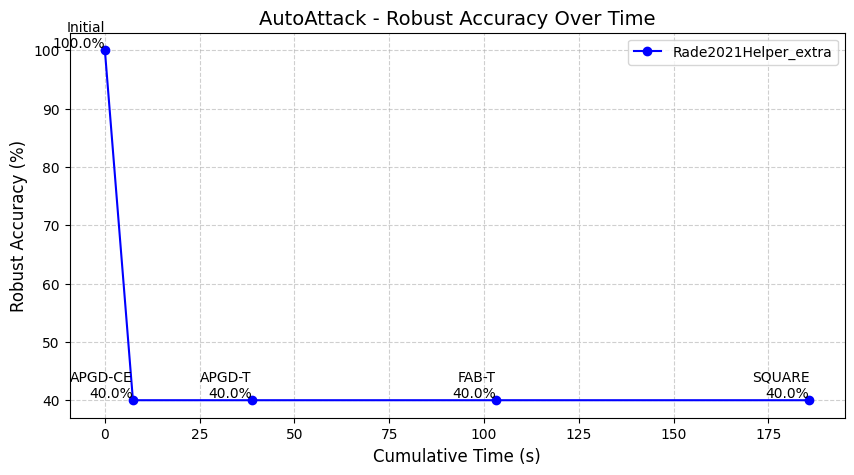

In [ ]:
# ----- Plotting AutoAttack Robust Accuracy Flow -----
plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx, (model_name, progress) in enumerate(attack_progress.items()):
    times, accs, steps = zip(*progress)
    plt.plot(times, accs, marker='o', linestyle='-', label=model_name, color=colors[idx % len(colors)])
    for t, acc, step in zip(times, accs, steps):
        plt.text(t, acc, f"{step}\n{acc:.1f}%", fontsize=10, verticalalignment='bottom', horizontalalignment='right')
plt.xlabel("Cumulative Time (s)", fontsize=12)
plt.ylabel("Robust Accuracy (%)", fontsize=12)
plt.title("AutoAttack - Robust Accuracy Over Time", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
autoattack_progress_path = os.path.join(output_dir, "autoattack_progress_all_models.png")
plt.savefig(autoattack_progress_path)
print(f"\nSaved AutoAttack progress plot (all models) to: {autoattack_progress_path}\n")
plt.show()

## FMN


--- Starting FMN Attack (Linf) on model Rade2021Helper_extra ---

Attack executed in 10.64 s
Predicted labels FMN (Linf): tensor([5, 0, 1, 2, 4, 4, 9, 4, 4, 9], device='cuda:0')
Robust Accuracy after FMN (Linf): 0/10 (0.00%)


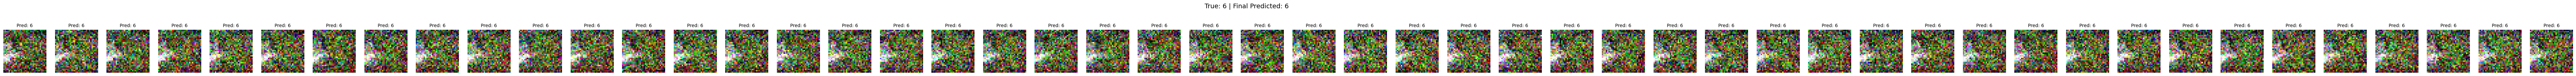

Smoothed Accuracy on FMN (Linf) Samples: 40.00%


--- Starting FMN Attack (L2) on model Rade2021Helper_extra ---

Attack executed in 11.21 s
Predicted labels FMN (L2): tensor([5, 0, 1, 2, 4, 4, 9, 4, 4, 9], device='cuda:0')
Robust Accuracy after FMN (L2): 0/10 (0.00%)


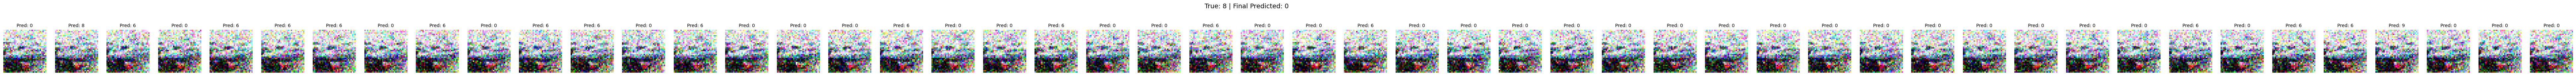

Smoothed Accuracy on FMN (L2) Samples: 40.00%


--- Starting FMN Attack (L1) on model Rade2021Helper_extra ---

Attack executed in 10.71 s
Predicted labels FMN (L1): tensor([5, 0, 1, 2, 4, 4, 9, 4, 5, 9], device='cuda:0')
Robust Accuracy after FMN (L1): 0/10 (0.00%)


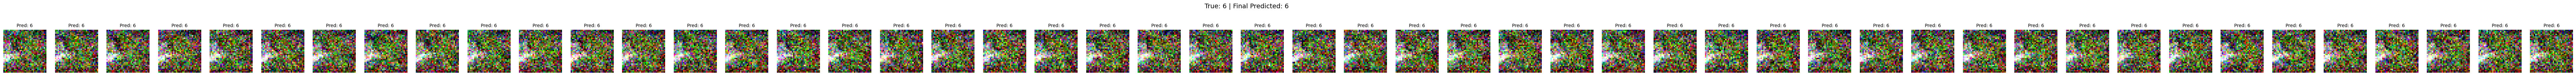

Smoothed Accuracy on FMN (L1) Samples: 40.00%


--- Starting FMN Attack (L0) on model Rade2021Helper_extra ---

Attack executed in 10.53 s
Predicted labels FMN (L0): tensor([5, 0, 1, 2, 4, 4, 9, 4, 5, 9], device='cuda:0')
Robust Accuracy after FMN (L0): 0/10 (0.00%)


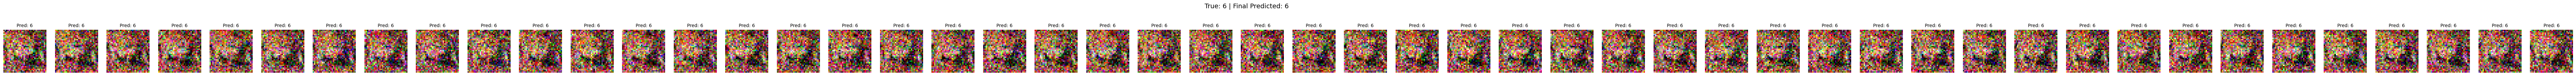

Smoothed Accuracy on FMN (L0) Samples: 40.00%



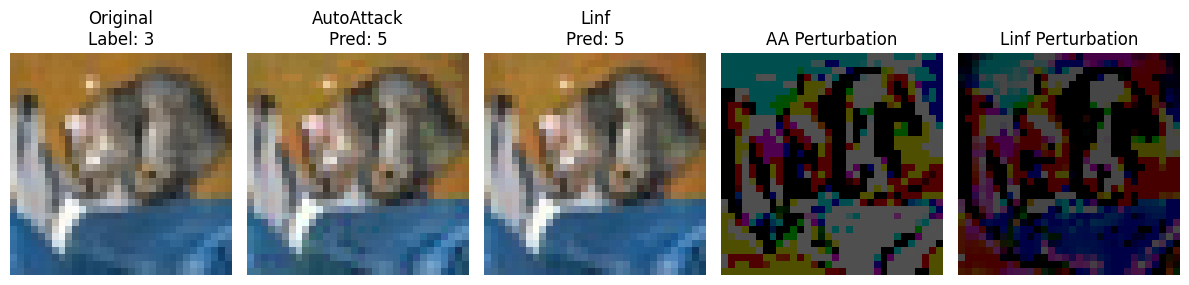

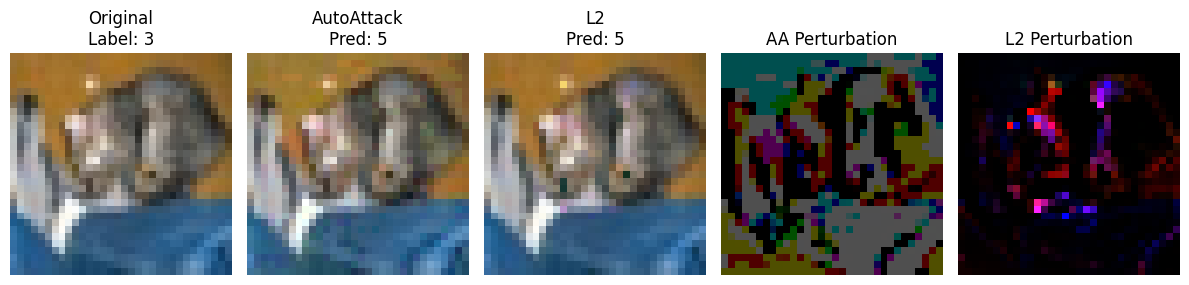

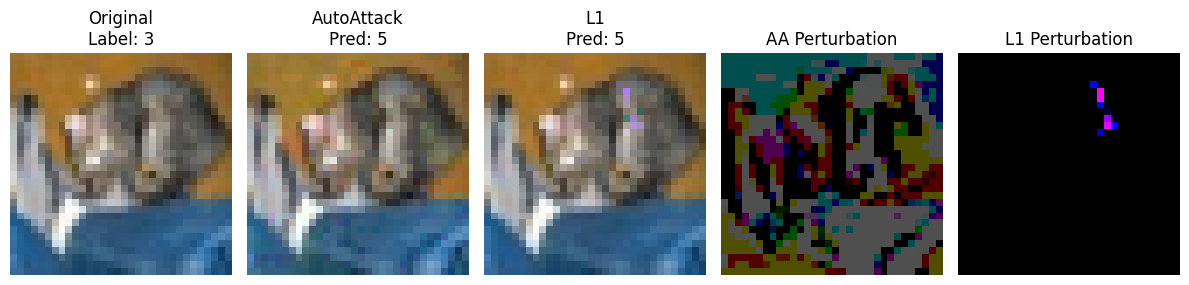

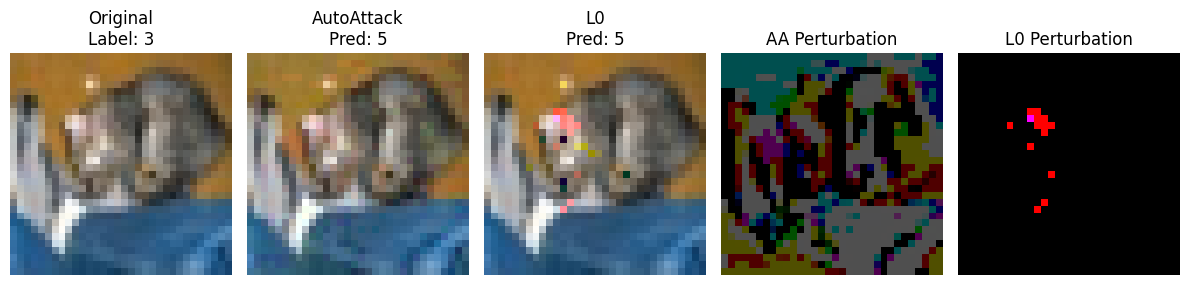

Function execution complete.


In [ ]:
# --- FMN Attacks ---
fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)
fmn_results = {}
adv_dict = {}

for norm, attack in fmn_attacks.items():
    print(f"\n--- Starting FMN Attack ({norm}) on model {model_name} ---")

    # Capture stdout to track attack progress
    old_stdout = sys.stdout
    sys.stdout = mystdout = io.StringIO()

    start_fmn = time.time()
    _, adv_images, _ = attack(fmodel, images, labels, epsilons=None)
    end_fmn = time.time()

    sys.stdout = old_stdout  # Restore stdout
    fmn_log = mystdout.getvalue()
    print(fmn_log)  # Print captured FMN attack log
    print(f"Attack executed in {end_fmn-start_fmn:.2f} s")

  # Get FMN predicted labels and wrong indexes
    _, predicted_fmn = model(adv_images).max(1)
    fmn_accuracy = torch.sum(labels == predicted_fmn).item() / len(labels) * 100
    perturbations = torch.norm((adv_images - images).reshape(adv_images.shape[0], -1), dim=1).cpu().numpy()

    fmn_results[norm] = {
        "accuracy": fmn_accuracy,
        "execution_time": end_fmn - start_fmn,
        "perturbations": perturbations
    }
    adv_dict[norm] = adv_images

    print(f"Predicted labels FMN ({norm}): {predicted_fmn}")
    correct = torch.sum(labels == predicted_fmn)
    total = len(labels)
    print(f"Robust Accuracy after FMN ({norm}): {correct}/{total} ({correct/total*100:.2f}%)")

    # randomized smoothing application
    smoothed_acc_fmn = randomized_smoothing(model, adv_images, labels, sigma, num_samples)
    print(f"Smoothed Accuracy on FMN ({norm}) Samples: {smoothed_acc_fmn:.2f}%\n")

save_and_plot_all_norms(model, model_name, images, labels, adv_images_autoattack, adv_dict, output_dir)

# --- Save and Plot Images for Each Norm ---
model_results[model_name] = {
    "clean_accuracy": clean_accuracy,
    "fmn_results": fmn_results
}


Samples with max perturbation <= 0.0314: 7
Samples with max perturbation > 0.0314: 3

Saved FMN-Linf histogram for Carmon2019Unlabeled to: /content/drive/My Drive/robustbench_results/Carmon2019Unlabeled_fmn_linf_histogram.png


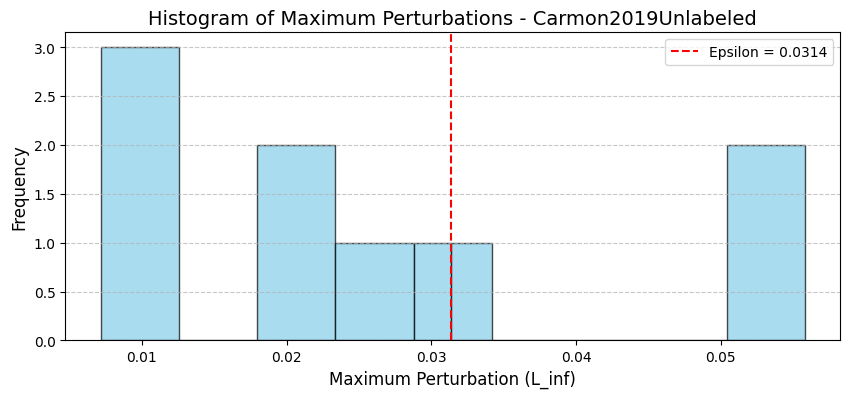

In [ ]:
# --- FMN-Linf Histogram of Maximum Perturbations ---
start_fmn = time.time()
_, adv_images_linf, _ = fmn_attacks["Linf"](fmodel, images, labels, epsilons=None)
end_fmn = time.time()

max_perturbations = []
for i in range(len(images)):
    original_image = images[i].cpu().numpy()
    adversarial_image = adv_images_linf[i].cpu().numpy()
    perturbation = np.abs(adversarial_image - original_image)
    max_perturbations.append(np.max(perturbation))

min_val = min(max_perturbations)
max_val = max(max_perturbations)
num_bins = n_examples
bins = np.linspace(min_val, max_val, num_bins)
if not np.any(np.isclose(bins, epsilon)):
    bins = np.sort(np.append(bins, epsilon))

samples_within_epsilon = sum(p <= epsilon for p in max_perturbations)
samples_outside_epsilon = len(max_perturbations) - samples_within_epsilon
print(f"\nSamples with max perturbation <= {epsilon:.4f}: {samples_within_epsilon}")
print(f"Samples with max perturbation > {epsilon:.4f}: {samples_outside_epsilon}\n")

plt.figure(figsize=(10, 4))
n, bins_used, patches = plt.hist(max_perturbations, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=epsilon, color='red', linestyle='--', label=f"Epsilon = {epsilon:.4f}")
plt.xlabel("Maximum Perturbation (L_inf)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(f"Histogram of Maximum Perturbations - {model_name}", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
fmn_linf_histogram_path = os.path.join(output_dir, f"{model_name}_fmn_linf_histogram.png")
plt.savefig(fmn_linf_histogram_path)
print(f"Saved FMN-Linf histogram for {model_name} to: {fmn_linf_histogram_path}")
plt.show()

linf_acc = 100 * torch.sum(labels == model(adv_images_linf).max(1)[1]).item() / len(labels)
fmn_results["Linf"] = {
        "accuracy": linf_acc,
        "execution_time": end_fmn - start_fmn,
        "perturbations": np.array(max_perturbations)
    }

model_results[model_name] = {
        "clean_accuracy": clean_accuracy,
        "fmn_results": fmn_results
    }